In [ ]:
import torch

#Set CPU as default device
default_device = torch.device("cpu")

#Set GPU for BERT training if available
bert_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Default device for general processing: {default_device}")
print(f"Device for BERT training: {bert_device}")


Default device for general processing: cpu
Device for BERT training: cuda


# 📧 Phishing Email Detection System Using BERT

In this project, we aim to build a phishing email detection model using deep learning techniques, with a focus on the BERT (Bidirectional Encoder Representations from Transformers) architecture.

Phishing emails are deceptive messages designed to trick users into revealing sensitive information. As attackers increasingly use AI to craft convincing emails, traditional rule-based filters fall short. This motivates the need for a more intelligent, language-aware detection system.

We begin by loading and preprocessing real-world phishing and legitimate email datasets. After tokenizing the data, we will train and evaluate a fine-tuned BERT model, and compare its performance to a logistic regression baseline. Our objective is to build a model that accurately classifies emails as "phishing" or "safe" using language patterns and contextual understanding.





In [ ]:
from google.colab import userdata
#KaggkeAPIKey = userdata.get('KaggleAPIKey')

---

# Mounting the google drive
We have to mount the google drive seeing as the files for the datasets are stored there

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# Cleaning Data across Datasets
Making all data sets consistent in labeling, data type and format:

1. "body": Holds the body of all emails.
2. "urls": Holds the boolean value for if a url is present or not (1: url, 0: no url)
3. "label": Holds the boolen value for if an email is Phishing or Safe (1: phishing, 0 not phishing)


- REMOVING UNPARSABLE/ ILLEGAL DATA
- You can view all data at "APS360_Final_Cleaned_Data" in shared folder

In [ ]:
!pip install xlsxwriter
!pip install pandas openpyxl

In [ ]:
import os
import pandas as pd
import re

#Folder with your CSVs
source_folder = '/content/drive/MyDrive/APS360 Notes/Datasets'
output_excel_path = os.path.join(source_folder, 'APS360_Final_Cleaned_Data.xlsx')

#Create the directory if it doesn't exist
os.makedirs(source_folder, exist_ok=True)

#Patterns to detect illegal Excel characters and ANSI sequences
ansi_pattern = re.compile(r'[\x1B\x1b]\[[0-9;]*[A-Za-z]|[0-9]+;[0-9]+[Hf]')
illegal_excel_chars = re.compile(r"[\x00-\x08\x0B-\x1F]")

#Function to check if a row contains illegal characters
def row_has_illegal_data(row):
    return any(
        ansi_pattern.search(str(cell)) or illegal_excel_chars.search(str(cell))
        for cell in row
    )

#Create ExcelWriter object
with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
    for filename in os.listdir(source_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(source_folder, filename)

            try:
                df = pd.read_csv(filepath, on_bad_lines='skip', encoding='utf-8', engine='python')
            except Exception as e:
                print(f"Skipping {filename} due to read error: {e}")
                continue

            #Drop rows with illegal characters
            df = df[~df.apply(row_has_illegal_data, axis=1)]

            #Clean and rename columns
            df.columns = [col.strip() for col in df.columns]
            col_map = {}
            for col in df.columns:
                if col.lower() in ['email text', 'text']:
                    col_map[col] = 'body'
                elif col.lower() == 'email type':
                    col_map[col] = 'label'
            df = df.rename(columns=col_map)

            #Add 'urls' column if missing
            if 'urls' not in df.columns and 'body' in df.columns:
                df['urls'] = df['body'].astype(str).apply(lambda x: 1 if 'http' in x else 0)

            #Keep only ['body', 'urls', 'label']
            keep_cols = [col for col in ['body', 'urls', 'label'] if col in df.columns]
            df = df[keep_cols]

            #Write sheet to Excel
            sheet_name = os.path.splitext(filename)[0][:31]
            try:
                df.to_excel(writer, sheet_name=sheet_name, index=False)
            except Exception as e:
                print(f"Failed to write sheet for {filename}: {e}")

print(f"Done! Cleaned Excel file saved at:\n{output_excel_path}")

Done! Cleaned Excel file saved at:
/content/drive/MyDrive/APS360 Notes/Datasets/APS360_Final_Cleaned_Data.xlsx


---
#Combine Data into One Large Dataset

- Takes all csv files and merges into one giant data set.
- Removes empty and null rows.
- Randomly shuffles and rearranges data.
- Makes sure that "label" and "urls" data is numerical later processing

In [ ]:
#This is a function Force string/int labels to integer 0 or 1
#Will be used later in combination (for cleaning purposes)

def clean_numerics(x):
    x_str = str(x).strip().lower()
    if x_str in ['1', 'phishing email']:
        return 1
    elif x_str in ['0', 'safe email']:
        return 0
    else:
        return 0

In [ ]:
#Load all sheets
all_sheets = pd.read_excel(output_excel_path, sheet_name=None)

#Concatenate all sheets into one DataFrame
phishing_df = pd.concat(all_sheets.values(), ignore_index=True)

#Drop rows with missing values (if any)
phishing_df = phishing_df.dropna()

#Shuffle dataset
phishing_df = phishing_df.sample(frac=1, random_state=42).reset_index(drop=True)

#Checks that this data is numerical
phishing_df['label'] = phishing_df['label'].apply(clean_numerics)
phishing_df['urls'] = phishing_df['urls'].apply(clean_numerics)


---
#Split Tensor Data into Training Validation and Testing Datasets

- Randomly split the encoded email data into 70% training, 15% validation, and 15% test sets.
- Each split contains input tensors from the tokenization (input_ids, attention_mask) along with corresponding labels and URL indicators (from phishing_df ).
- This prepares the data for use in training and evaluating an AI classification model.




In [ ]:
from sklearn.model_selection import train_test_split
import torch

#Convert labels and urls to tensors
label = torch.tensor(phishing_df['label'].values)
urls = torch.tensor(phishing_df['urls'].values)

#First split into training data for 70% and temp data (vaidation + testing) for 30%
train_idx, temp_idx = train_test_split(range(len(label)), test_size=0.3, random_state=42)

#Then split temp into validation and testing 15% each
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)


In [ ]:
# splitting the bodies for train, val, and test data
train_bodies = phishing_df['body'][train_idx].tolist()
val_bodies = phishing_df['body'][val_idx].tolist()
test_bodies = phishing_df['body'][test_idx].tolist()

# converting the training, val, and test urls and labels to tensors
train_urls = torch.tensor(phishing_df['urls'][train_idx].tolist())
train_labels = torch.tensor(phishing_df['label'][train_idx].tolist())


val_urls = torch.tensor(phishing_df['urls'][val_idx].tolist())
val_labels = torch.tensor(phishing_df['label'][val_idx].tolist())


test_urls = torch.tensor(phishing_df['urls'][test_idx].tolist())
test_labels = torch.tensor(phishing_df['label'][test_idx].tolist())

In [ ]:
N = {len(phishing_df)}
phishing_df['urls'].value_counts()
phishing_df['label'].value_counts()

print("Number of emails", N)
print("\n")
print("Number of phishing emails", phishing_df['label'].value_counts()[1])
print("Number of safe emails", phishing_df['label'].value_counts()[0])
print("\n")
print("Number of emails with urls", phishing_df['urls'].value_counts()[1])
print("Number of emails without urls", phishing_df['urls'].value_counts()[0])
# Display first 5 cleaned samples
phishing_df.head()


Number of emails {67126}


Number of phishing emails 36604
Number of safe emails 30522


Number of emails with urls 38111
Number of emails without urls 29015


,body,urls,label
0,\nThey look and feel exactly like the real thi...,1,1
1,\n\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\...,0,1
2,"Ranked #1 Men's Supplement by GQ in 2007, disc...",1,1
3,No girl will now resist a temptation to go wit...,1,1
4,"Dear Sarah, I hope this email finds you well. ...",1,0


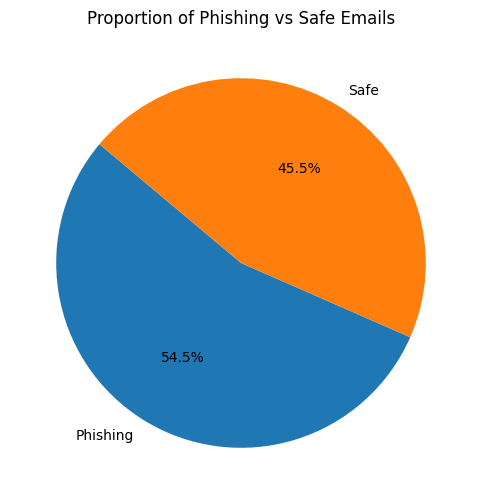

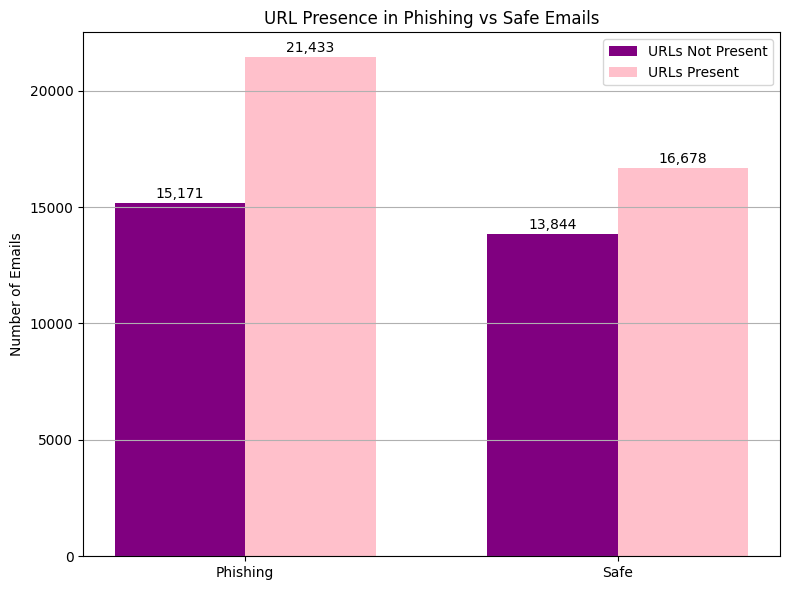

In [ ]:
import matplotlib.pyplot as plt

"""PLOT PIE CHART OF PHISHING VS SAFE EMAILS"""

#Data
labels = ['Phishing', 'Safe']
values = [phishing_df['label'].value_counts()[1], phishing_df['label'].value_counts()[0]]

#Plot
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Phishing vs Safe Emails')
plt.show()



"""PLOT BAR GRAPH OF URLS"""

#Count combinations of label and url presence
group_counts = phishing_df.groupby(['label', 'urls']).size().unstack(fill_value=0)

#Data
labels = ['Phishing', 'Safe']  # label 1 = Phishing, 0 = Safe
with_urls = [group_counts.loc[1, 1], group_counts.loc[0, 1]]
without_urls = [group_counts.loc[1, 0], group_counts.loc[0, 0]]

x = range(len(labels))  # [0, 1]
bar_width = 0.35

#Plot bars
plt.figure(figsize=(8, 6))
bars1 = plt.bar([i - bar_width/2 for i in x], without_urls, width=bar_width, label='URLs Not Present', color='purple')
bars2 = plt.bar([i + bar_width/2 for i in x], with_urls, width=bar_width, label='URLs Present', color='pink')

#Add value labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:,}',  # add comma to large numbers
                 ha='center', va='bottom', fontsize=10)

#Formatting
plt.xticks(x, labels)
plt.ylabel('Number of Emails')
plt.title('URL Presence in Phishing vs Safe Emails')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()



---
# **Tokenize the training, validation, and testing bodies**
We are now tokenizing the data that we have previously split.

We are creating classes that define how to tokenize the data but this will not actually occur until the BERT model is used. The class highlights the main functionality:


**Initialization**: Initialize the dataset with text data, URLs, labels, and tokenizer.

        Args:
        - texts (List[str]): List of email bodies.
        - urls (List[str] or similar): Corresponding list of URLs in the emails.
        - labels (List[int]): Labels (e.g., 0 for ham, 1 for phishing).
        - tokenizer (BertTokenizer): Pretrained BERT tokenizer.
        - max_length (int): Maximum sequence length for padding/truncation.


**Retrival/Tokenization:** Retrieve a single sample from the dataset and tokenize it.

        Args:
        - idx (int): Index of the sample to fetch.

        Returns:
        - A dictionary containing:
          - 'input_ids': token IDs for the text
          - 'attention_mask': binary mask for padded tokens
          - 'urls': original URL
          - 'labels': ground truth label
       

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

#Load the pretrained BERT tokenizer (lowercase version of BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Define a custom dataset class for phishing email detection
class PhishingEmailDataset(Dataset):
    def __init__(self, texts, urls, labels, tokenizer, max_length=256):
        #Initialize the dataset with text data, URLs, labels, and tokenizer.
        self.texts = texts
        self.urls = urls
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        #Return the total number of samples in the dataset
        return len(self.texts)

    def __getitem__(self, idx):

        #Retrieve a single sample from the dataset and tokenize it.

        encoding = self.tokenizer(
            self.texts[idx],              #The email body
            truncation=True,             #Truncate if it exceeds max_length
            padding='max_length',        #Pad to max_length
            max_length=self.max_length,  #Set max sequence length
            return_tensors='pt'          #Return PyTorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),            #Token IDs (squeezed to remove extra dimension)
            'attention_mask': encoding['attention_mask'].squeeze(),  #Attention mask (squeezed)
            'urls': self.urls[idx],                                  #Corresponding URL
            'labels': self.labels[idx]                               #Label for classification
        }

#These assume you have train_bodies, train_urls, and train_labels already defined
train_dataset = PhishingEmailDataset(train_bodies, train_urls, train_labels, tokenizer)
val_dataset   = PhishingEmailDataset(val_bodies, val_urls, val_labels, tokenizer)
test_dataset  = PhishingEmailDataset(test_bodies, test_urls, test_labels, tokenizer)


batch_size = 8  #Number of samples per batch

#For training
train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

#For validation and testing
val_loader = DataLoader(
    val_dataset,
    sampler=RandomSampler(val_dataset),
    batch_size=batch_size
)

test_loader = DataLoader(
    test_dataset,
    sampler=RandomSampler(test_dataset),
    batch_size=batch_size
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

---
# **Converting the Tokenized Data to Complete Tensors**


# Tokenization for Logisitic Regression

This implementation of tokenization will be used specifically for the logistic regression model. The implementation steps include:
  1. Vectorizing the sentences
  2. Counting the occurances of words
  3. Vectorizing the numbers for the corresponding words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,3))

train_bow = vectorizer.fit_transform(train_bodies)
val_bow = vectorizer.transform(val_bodies)
test_bow = vectorizer.transform(test_bodies)

# **Implementing the Logistic Regression Model**
add description here after

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize Logistic Regression with suitable parameters
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on Bag-of-Words training data
log_reg.fit(train_bow, train_labels.numpy())

# Predict on validation set
val_preds = log_reg.predict(val_bow)

# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels.numpy(), val_preds)
print(f"Validation Accuracy (Logistic Regression Baseline): {val_accuracy * 100:.2f}%")

Validation Accuracy (Logistic Regression Baseline): 98.44%


---
#**Apply Pretrained BERT Model**

- Initialize Pretrained BERT Model Transformer
- Use AdamW Optimizer for optimization and loss
- Define Dataloaders from tensors
- Train the Model
- Use Early Stopping in pretrained model

In [ ]:

import torch.nn as nn
from transformers import BertModel

# Custom BERT Classifier with Dropout
class BertClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3, num_labels=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}


In [ ]:

# Instantiate model
model = BertClassifier(dropout_rate=0.3, num_labels=2).to(bert_device)

from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=2e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

best_val_error = float('inf')
patience = 2
patience_counter = 0

train_loss_list = []
val_loss_list = []
train_err_list = []
val_err_list = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_train_err = 0

    for step, batch in enumerate(train_loader):
        b_input_ids = batch['input_ids'].to(bert_device)
        b_attention_mask = batch['attention_mask'].to(bert_device)
        b_labels = batch['labels'].to(bert_device)

        optimizer.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs['loss']
        logits = outputs['logits']

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        preds = logits.argmax(dim=1)
        total_train_err += (preds != b_labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_error = total_train_err / len(train_loader.dataset)

    train_loss_list.append(avg_train_loss)
    train_err_list.append(train_error)

    model.eval()
    total_val_loss = 0
    total_val_err = 0
    with torch.no_grad():
        for batch in val_loader:
            b_input_ids = batch['input_ids'].to(bert_device)
            b_attention_mask = batch['attention_mask'].to(bert_device)
            b_labels = batch['labels'].to(bert_device)

            outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs['loss']
            logits = outputs['logits']

            total_val_loss += loss.item()
            preds = logits.argmax(dim=1)
            total_val_err += (preds != b_labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_error = total_val_err / len(val_loader.dataset)

    val_loss_list.append(avg_val_loss)
    val_err_list.append(val_error)

    print(f"Epoch {epoch+1}: Train loss = {avg_train_loss:.4f}, Val loss = {avg_val_loss:.4f}, Train error = {train_error:.4f}, Val error = {val_error:.4f}")

    if val_error < best_val_error:
        best_val_error = val_error
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Epoch 1: Train loss = 0.1068, Val loss = 0.0316, Train error = 0.0447, Val error = 0.0122
Epoch 2: Train loss = 0.0205, Val loss = 0.0241, Train error = 0.0077, Val error = 0.0090
Epoch 3: Train loss = 0.0091, Val loss = 0.0269, Train error = 0.0043, Val error = 0.0092


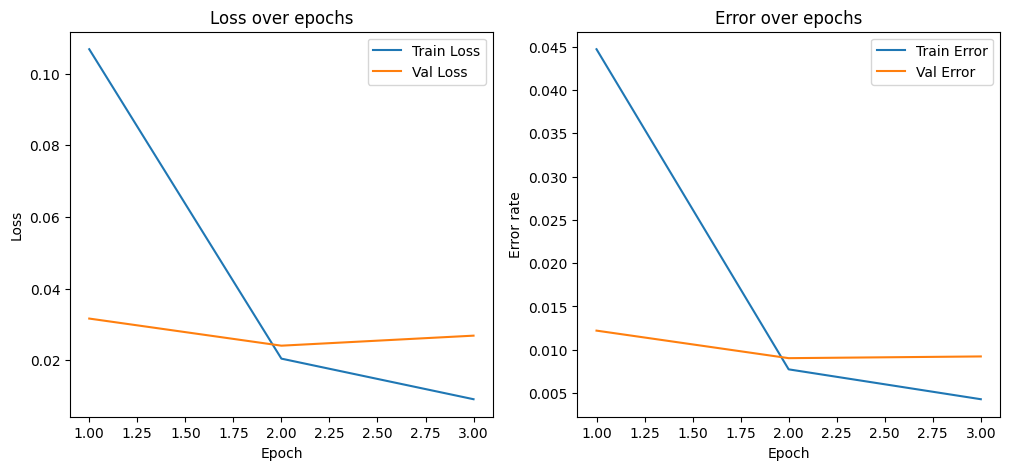

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12,5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

# Plot error
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_err_list, label='Train Error')
plt.plot(epochs_range, val_err_list, label='Val Error')
plt.xlabel('Epoch')
plt.ylabel('Error rate')
plt.title('Error over epochs')
plt.legend()

plt.show()

# Cleaning up RAM usage **(Place this block at the bottom of the code for now please)**
We are going to clean up some data to prevent high usage of memory. Please note, you can only run this cell once if you don't reinstantiate these variables

In [ ]:
import gc

del phishing_df

del train_bodies, val_bodies, test_bodies

del tokenizedTraining, tokenizedValidation, tokenizedTest

gc.collect()